# **ADVANCED MACHINE LEARNING FINAL PROJECT**

##### Authors: Dario Della Mura - David Doci

##### Course: Advanced Machine Learning

##### Master's Degree: Data Science

##### Anno accademico: 2020/2021

Setting Colab GPU environment

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Feb 10 01:51:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    70W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Import Librerie e Dataset

In [ ]:
# import Fruits-360 dataset from Github

!git clone 'https://github.com/Horea94/Fruit-Images-Dataset.git'

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8672/8672), done.
remote: Total 385858 (delta 36), reused 8670 (delta 21), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 27.95 MiB/s, done.
Resolving deltas: 100% (1196/1196), done.
Checking out files: 100% (90503/90503), done.


In [ ]:
# Generiche
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
import glob
import cv2

# Keras
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Dropout, Activation, AveragePooling2D
from keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers 
import keras
from tensorflow.keras.applications.vgg16 import VGG16
from keras import Model
from keras.preprocessing.image import ImageDataGenerator

# Sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

np.random.seed(1234)
tf.random.set_seed(1234)

## Data pre-processing and Data Augmentation

In [ ]:
# Pre-processing for vgg16 architecture and data augmentation for images in training set
%%time 

DIR_TRAIN = '/content/Fruit-Images-Dataset/Training'

image_size = (64,64,3)

datagen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, horizontal_flip = True, preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

training_set = datagen.flow_from_directory( DIR_TRAIN,
                                            target_size = image_size[:2],  
                                            batch_size = 216, 
                                            class_mode = 'categorical', 
                                            color_mode='rgb'
                                          )

Found 67692 images belonging to 131 classes.
CPU times: user 2.65 s, sys: 110 ms, total: 2.76 s
Wall time: 3.28 s


In [ ]:
# Pre-processing for vgg16 architecture and data augmentation for images in test set

%%time 
DIR_TEST = '/content/Fruit-Images-Dataset/Test'
image_size = (64,64,3)

datagen_ = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, horizontal_flip = True, preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

test_set = datagen_.flow_from_directory( DIR_TEST,
                                        target_size = image_size[:2],  
                                        batch_size = 216, 
                                        class_mode = 'categorical', 
                                        color_mode='rgb',
                                        shuffle = False
                                      )

Found 22688 images belonging to 131 classes.
CPU times: user 929 ms, sys: 37.2 ms, total: 966 ms
Wall time: 1.34 s


## TRANSFER LEARNING WITH VGG16

In [ ]:
#import vgg16 architecture
base_model = VGG16(input_shape=(64,64,3),include_top = False, weights='imagenet')

# application of transfer learning and setting output layers for the 131 classes of the task problem

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)

x = keras.layers.Dense(131, activation='softmax')(x)

model = Model(inputs = base_model.input, outputs = x)


In [ ]:
%%time 

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

CPU times: user 12.8 ms, sys: 1.1 ms, total: 13.9 ms
Wall time: 40.8 ms


In [ ]:
%%time

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit_generator(training_set, validation_data= test_set, epochs=40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/40
314/314 [==============================] - 192s 587ms/step - loss: 1.5552 - accuracy: 0.7468 - val_loss: 0.9508 - val_accuracy: 0.8232
Epoch 2/40
314/314 [==============================] - 179s 569ms/step - loss: 0.4578 - accuracy: 0.9411 - val_loss: 0.6281 - val_accuracy: 0.8714
Epoch 3/40
314/314 [==============================] - 178s 567ms/step - loss: 0.2702 - accuracy: 0.9670 - val_loss: 0.4791 - val_accuracy: 0.8943
Epoch 4/40
314/314 [==============================] - 178s 568ms/step - loss: 0.1892 - accuracy: 0.9780 - val_loss: 0.4091 - val_accuracy: 0.9104
Epoch 5/40
314/314 [==============================] - 178s 567ms/step - loss: 0.1425 - accuracy: 0.9845 - val_loss: 0.3448 - val_accuracy: 0.9230
Epoch 6/40
314/314 [==============================] - 177s 565ms/step - loss: 0.1131 - accuracy: 0.9879 - val_loss: 0.3184 - val_accuracy: 0.9244
Epoch 7/40
314/314 [==============================] - 178s 568ms/step - loss: 0.0928 - accuracy: 0.9899 - val_loss: 0.2789 -

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#save model for future evaluation

# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/model_tl2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/model_tl2.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
'''#upload pre-trained model
from keras.models import model_from_json
json_file = open('model_tl.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_tl.h5")
print("Loaded model from disk")'''

'#upload pre-trained model\nfrom keras.models import model_from_json\njson_file = open(\'model_tl.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("model_tl.h5")\nprint("Loaded model from disk")'

## RESULTS

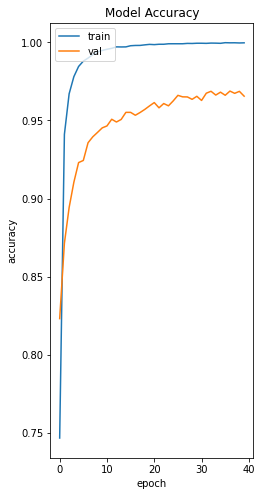

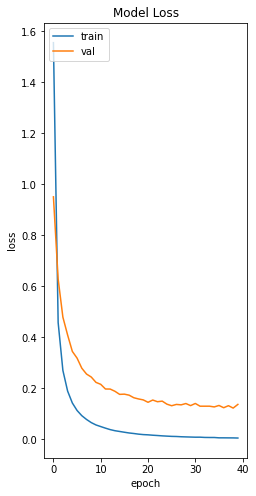

CPU times: user 389 ms, sys: 12.1 ms, total: 401 ms
Wall time: 431 ms


In [ ]:
%%time

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
evalu = model.evaluate_generator(test_set)
print(model.metrics_names)
print(evalu)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


['loss', 'accuracy']
[0.13860280811786652, 0.9643423557281494]


In [ ]:
# score on unseen test images
score_test = model.evaluate(test_set)
print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])

106/106 [==============================] - 46s 430ms/step - loss: 0.1309 - accuracy: 0.9661
Test loss: 0.13090264797210693
Test accuracy: 0.9661495089530945


In [ ]:
from sklearn.metrics import  accuracy_score
#val_data_gen.reset()
preds = model.predict_generator(test_set)

preds = np.argmax(preds, axis=1)

labels =test_set.labels
y_true = labels



# confusion_matrix(y_true, y_pred)
print("Accuracy:", accuracy_score(y_true, preds))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy: 0.9647831452750353


In [ ]:
import pandas as pd

cm = confusion_matrix(y_true, preds)

df = pd.DataFrame(cm)

In [ ]:
df.to_excel('cf_TL.xlsx')